In [2]:
#creates 1 output file with TU counts per 1 input file (containing stitched reads) and one .csv with 1bp mismatch combos

from collections import defaultdict
import csv
import os
import glob
import pandas as pd
from Bio import SeqIO

# Function to generate all sequences that are up to 1 bp different from input
def generate_single_mismatch_variants(seq):
    bases = ['A', 'C', 'G', 'T']
    variants = set()
    for i, base in enumerate(seq):
        for b in bases:
            if b != base:
                variant = seq[:i] + b + seq[i+1:]
                variants.add(variant)
    return variants

# Function to write summary CSV
def write_summary_csv(summary_data, summary_path):
    summary_df = pd.DataFrame(summary_data, columns=[
        "File Name",
        "Number of Reads Processed",
        "Length of read unexpected, not processed",
        "Both Univ Primers Found",
        "Perfect Match Found",
        "Perfect Match Found (1bp mismatch)",
        "Unambiguous 1-bp Mismatches Assigned",
        "Ambiguous 1-bp Mismatches Discarded",
        "Primers Found but No Perfect Match",
        "Less than Two Univ Primers Found",
        "% Usable Reads",
        "% Usable Barcodes",
        "% Perfect Matches of Primers Found",
        "% 1-bp Mismatches of Primers Found",
        "% ≥2-bp Mismatches of Primers Found"
    ])
    summary_df.to_csv(summary_path, index=False)

# Function to process individual input files and generate output file
def process_reads(file_path, output_file, summary_data):
    combos_dir = os.path.join(os.path.dirname(output_file), "output_csvs")
    mismatch_dir = os.path.join(os.path.dirname(output_file), "one_bp_mismatches")
    base_filename = os.path.basename(output_file)
    combos_output_file = os.path.join(combos_dir, base_filename)
    mismatch_output_file = os.path.join(mismatch_dir, "mismatch_" + base_filename + ".csv")
    os.makedirs(combos_dir, exist_ok=True)
    os.makedirs(mismatch_dir, exist_ok=True)

    KEY_REGION_1_START, KEY_REGION_1_END = 0, 35
    KEY_1 = "GGTCGCAAGATGGGACACG"
    KEY_REGION_2_START, KEY_REGION_2_END = 40, 160
    KEY_2 = "GTGCCGCTCATTTGCCTGG"

    bc_counts_by_sequence = defaultdict(int)
    barcode_library_path = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/LibJTR012_Barcodes.csv' #change as needed
    barcode_df = pd.read_csv(barcode_library_path, encoding='utf-8-sig')
    barcode_number_identifier = dict(zip(barcode_df.iloc[:, 2], barcode_df.iloc[:, 0]))
    barcode_letter_identifier = dict(zip(barcode_df.iloc[:, 2], barcode_df.iloc[:, 1]))

    for bc in barcode_letter_identifier:
        bc_counts_by_sequence[bc] = 0

    one_mismatch_lookup = defaultdict(list)
    for bc in bc_counts_by_sequence:
        for variant in generate_single_mismatch_variants(bc):
            one_mismatch_lookup[variant].append(bc)

    one_bp_mismatch_counter = defaultdict(lambda: {"Count": 0, "Real_Barcodes": set(), "Real_TUs": set()})

    try:
        count = sum(1 for _ in SeqIO.parse(file_path, "fastq"))
        print(f"File {file_path} contains {count} records.")
    except ValueError as e:
        print(f"Error in file {file_path}: {e}")
        return

    counters = defaultdict(int)

    try:
        for record in SeqIO.parse(file_path, "fastq"):
            if len(record.seq) < 160:
                counters["num_reads_processed"] += 1
                read_sequence = str.upper(str(record.seq))
                key_region_1 = read_sequence[KEY_REGION_1_START:KEY_REGION_1_END]
                key_region_2 = read_sequence[KEY_REGION_2_START:KEY_REGION_2_END]

                key_index_1 = key_region_1.find(KEY_1)
                key_index_2 = key_region_2.find(KEY_2)

                if key_index_1 >= 0 and key_index_2 >= 0:
                    counters["both_univ_primers_found"] += 1
                    start_index_1 = key_index_1 + KEY_REGION_1_START + len(KEY_1)
                    guide_1 = read_sequence[start_index_1:start_index_1 + 8]
                    start_index_2 = key_index_2 + KEY_REGION_2_START - 8
                    guide_2 = read_sequence[start_index_2:start_index_2 + 8]
                    guide_combined = guide_1 + guide_2

                    if guide_combined in bc_counts_by_sequence:
                        bc_counts_by_sequence[guide_combined] += 1
                        counters["perfect_match"] += 1

                    elif guide_combined in one_mismatch_lookup:
                        matched_real_barcodes = one_mismatch_lookup[guide_combined]
                        if len(matched_real_barcodes) == 1:
                            real_bc = matched_real_barcodes[0]
                            bc_counts_by_sequence[real_bc] += 1
                            counters["perfect_match_but_one"] += 1
                            counters["unambiguous_1bp_mismatch"] += 1
                        else:
                            counters["ambiguous_1bp_mismatch"] += 1
                            counters["univ_primer_found_but_no_perfect_match"] += 1

                        matched_TUs = [barcode_letter_identifier.get(bc, "Unknown") for bc in matched_real_barcodes]
                        one_bp_mismatch_counter[guide_combined]["Count"] += 1
                        one_bp_mismatch_counter[guide_combined]["Real_Barcodes"].update(matched_real_barcodes)
                        one_bp_mismatch_counter[guide_combined]["Real_TUs"].update(matched_TUs)

                    else:
                        counters["univ_primer_found_but_no_perfect_match"] += 1
                else:
                    counters["less_than_two_univ_primers_found"] += 1
            else:
                counters["len_unexpected"] += 1
    except ValueError as e:
        print(f"Error while processing file {file_path}: {e}")
        return

    usable_reads = round(counters["both_univ_primers_found"] / counters["num_reads_processed"] * 100, 1) if counters["num_reads_processed"] else 0
    usable_barcodes = round((counters["perfect_match"] + counters["perfect_match_but_one"]) / counters["both_univ_primers_found"] * 100, 1) if counters["both_univ_primers_found"] else 0
    total = counters["both_univ_primers_found"]
    percent_perfect = round(counters["perfect_match"] / total * 100, 2) if total else 0.0
    percent_1bp = round(counters["perfect_match_but_one"] / total * 100, 2) if total else 0.0
    percent_nomatch = round(counters["univ_primer_found_but_no_perfect_match"] / total * 100, 2) if total else 0.0

    summary_data.append([
        file_path,
        counters["num_reads_processed"],
        counters["len_unexpected"],
        counters["both_univ_primers_found"],
        counters["perfect_match"],
        counters["perfect_match_but_one"],
        counters["unambiguous_1bp_mismatch"],
        counters["ambiguous_1bp_mismatch"],
        counters["univ_primer_found_but_no_perfect_match"],
        counters["less_than_two_univ_primers_found"],
        usable_reads,
        usable_barcodes,
        percent_perfect,
        percent_1bp,
        percent_nomatch
    ])

    with open(combos_output_file, mode='w', newline='', encoding='utf-8-sig') as outfile:
        mywriter = csv.writer(outfile, delimiter=',')
        mywriter.writerow(["sample file path", file_path])
        mywriter.writerow(["number of reads processed:", counters["num_reads_processed"]])
        mywriter.writerow(["reads not processed (unexpected length)", counters["len_unexpected"]])
        mywriter.writerow(["both univ primers found", counters["both_univ_primers_found"]])
        mywriter.writerow(["found bc in library (perfect match):", counters["perfect_match"]])
        mywriter.writerow(["found bc with 1 bp mismatch:", counters["perfect_match_but_one"]])
        mywriter.writerow(["unambiguous 1-bp mismatches assigned:", counters["unambiguous_1bp_mismatch"]])
        mywriter.writerow(["ambiguous 1-bp mismatches discarded:", counters["ambiguous_1bp_mismatch"]])
        mywriter.writerow(["primers found but no barcode match:", counters["univ_primer_found_but_no_perfect_match"]])
        mywriter.writerow(["less than two univ primers found", counters["less_than_two_univ_primers_found"]])
        mywriter.writerow(["% usable reads", usable_reads])
        mywriter.writerow(["% usable barcodes from usable reads", usable_barcodes])
        mywriter.writerow(["% perfect matches of primers found", percent_perfect])
        mywriter.writerow(["% 1-bp mismatches of primers found", percent_1bp])
        mywriter.writerow(["% ≥2-bp mismatches of primers found", percent_nomatch])

        for key, val in bc_counts_by_sequence.items():
            mywriter.writerow([barcode_number_identifier[key], barcode_letter_identifier[key], key, val])

    if one_bp_mismatch_counter:
        mismatch_df = pd.DataFrame([
            {
                "Read Sequence": seq,
                "Closest Real Barcode(s)": ";".join(sorted(info["Real_Barcodes"])),
                "Closest TU(s)": ";".join(sorted(info["Real_TUs"])),
                "Count": info["Count"]
            } for seq, info in one_bp_mismatch_counter.items()
        ])
        mismatch_df.to_csv(mismatch_output_file, index=False)
        print(f"Saved {len(mismatch_df)} unique 1-bp mismatch barcodes to {mismatch_output_file}")
    else:
        print("No 1-bp mismatch records to save for this file.")

# ==== Pipeline Driver ====
input_dir = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Stitched' #change as needed
output_dir = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts' #change as needed
summary_path = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Val_SummaryData.csv' #change as needed

input_files = sorted(glob.glob(os.path.join(input_dir, 'stitched_BS*')))
output_files = [os.path.join(output_dir, f'Counts_{os.path.basename(f).replace("stitched_", "")}') for f in input_files]

summary_data = []
for file_path, output_file in zip(input_files, output_files):
    process_reads(file_path, output_file, summary_data)

write_summary_csv(summary_data, summary_path)


File /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Stitched/stitched_BS27976A contains 376422 records.
Saved 228 unique 1-bp mismatch barcodes to /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/one_bp_mismatches/mismatch_Counts_BS27976A.csv
File /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Stitched/stitched_BS27977A contains 257383 records.
Saved 272 unique 1-bp mismatch barcodes to /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/one_bp_mismatches/mismatch_Counts_BS27977A.csv
File /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Stitched/stitched_BS27978A contains 801353 records.
Saved 345 unique 1-bp mismatch barcodes to /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/

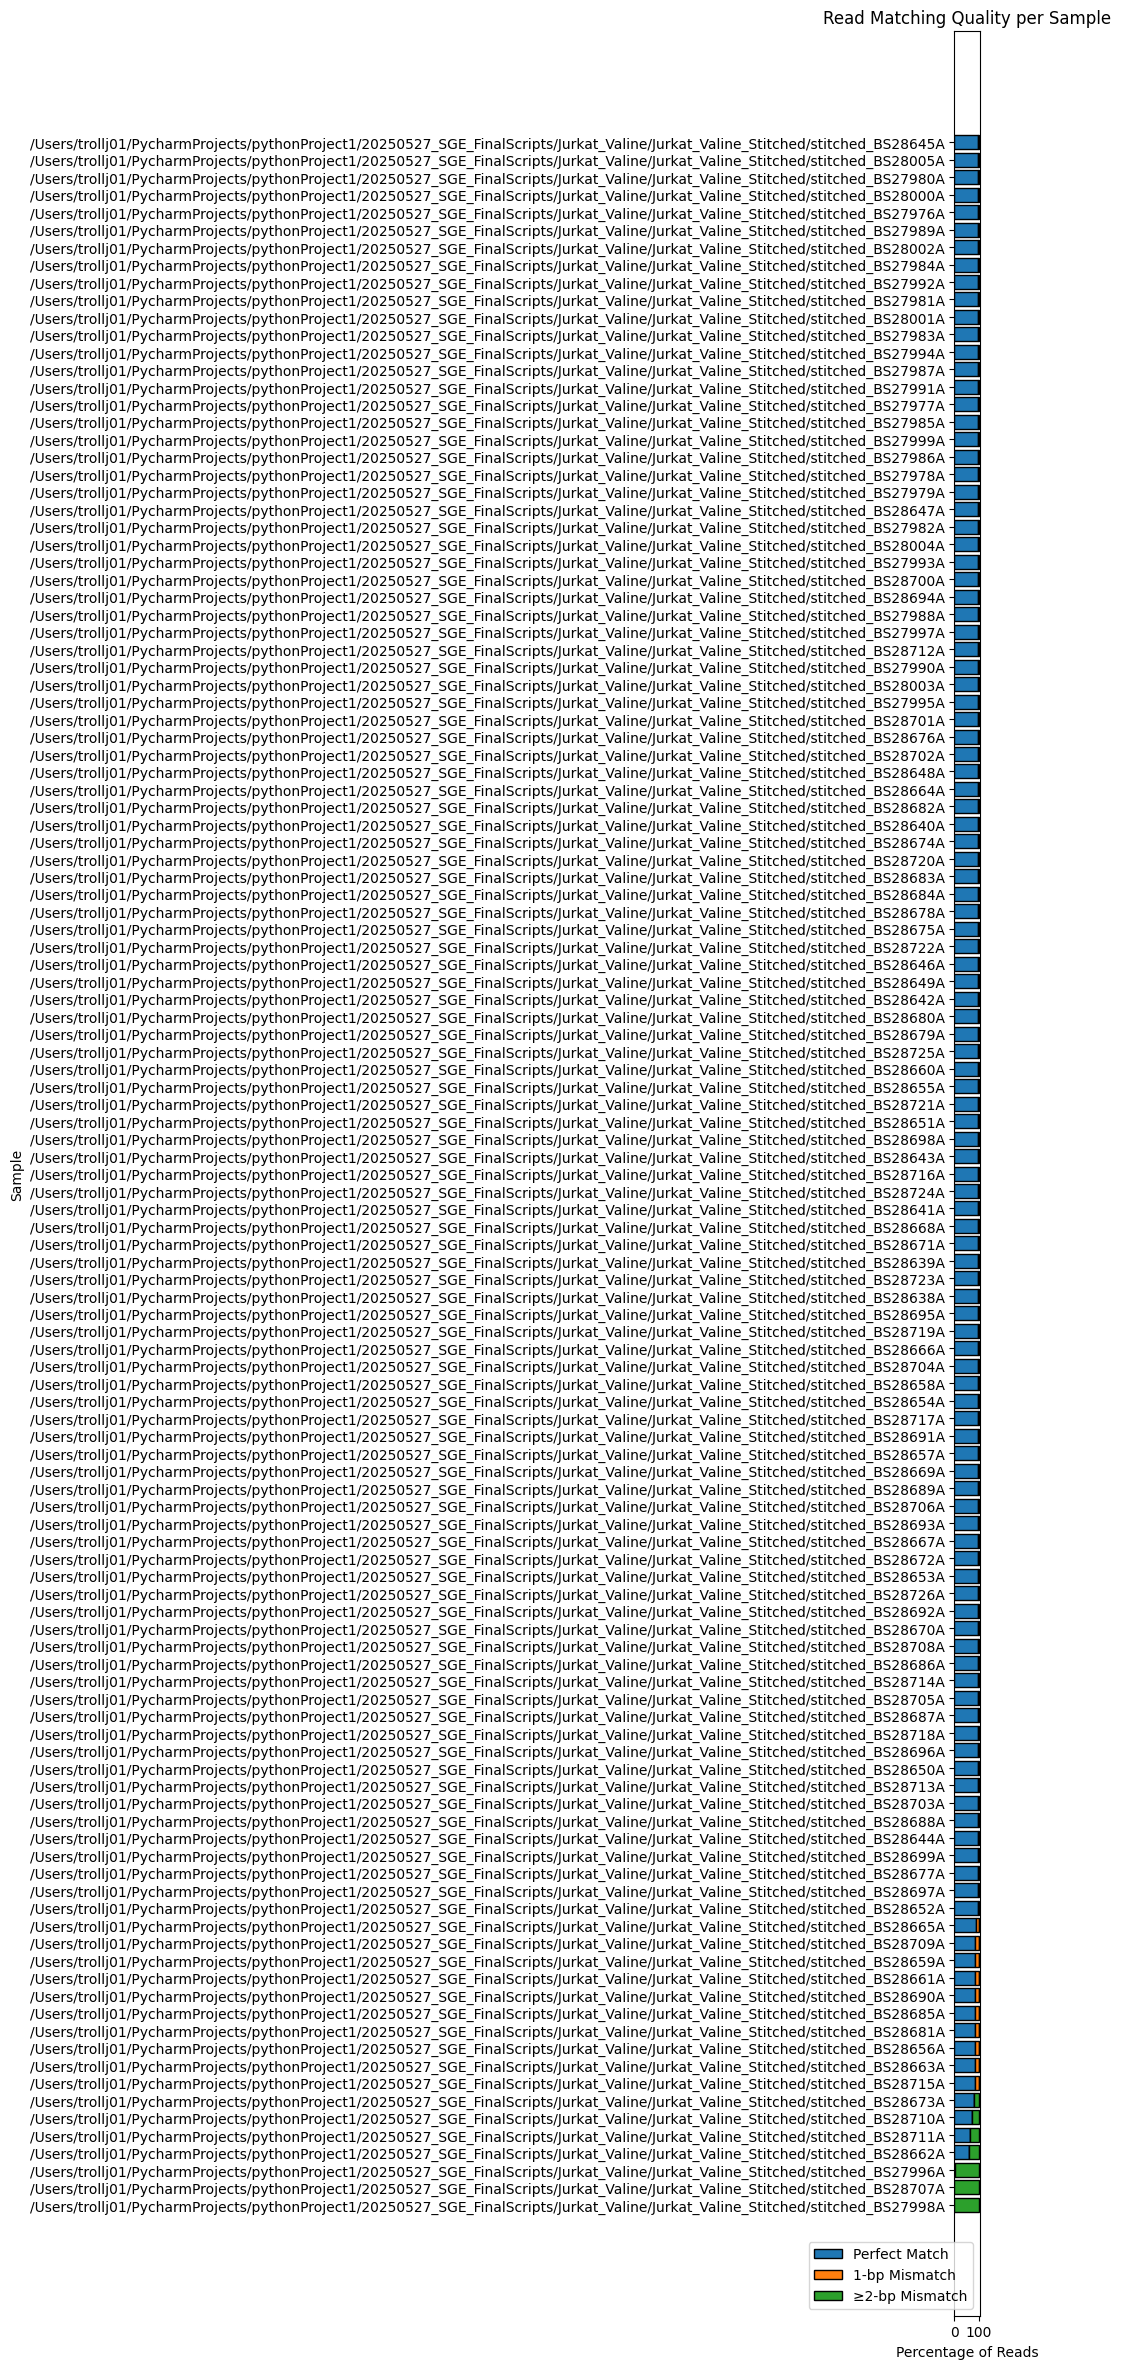

In [3]:
#visualize summary data

import pandas as pd
import matplotlib.pyplot as plt

# Load your summary CSV
summary_file = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Val_SummaryData.csv'
summary_df = pd.read_csv(summary_file)

# Sort by % Perfect Matches
summary_df = summary_df.sort_values("% Perfect Matches of Primers Found", ascending=False)

# Set up data for the stacked bar
perfect = summary_df["% Perfect Matches of Primers Found"]
one_bp = summary_df["% 1-bp Mismatches of Primers Found"]
two_bp = summary_df["% ≥2-bp Mismatches of Primers Found"]

sample_names = summary_df["File Name"]

# Set figure size dynamically
fig_height = max(8, len(sample_names) * 0.2)  # Auto-adjust based on number of samples
plt.figure(figsize=(10, fig_height))

# Make horizontal stacked bars
plt.barh(sample_names, perfect, label="Perfect Match", edgecolor='black')
plt.barh(sample_names, one_bp, left=perfect, label="1-bp Mismatch", edgecolor='black')
plt.barh(sample_names, two_bp, left=perfect + one_bp, label="≥2-bp Mismatch", edgecolor='black')

# Labels and title
plt.xlabel("Percentage of Reads")
plt.ylabel("Sample")
plt.title("Read Matching Quality per Sample")
plt.legend(loc='lower right')

# Tidy up
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest perfect match at the top
plt.show()
